In [1]:
'''
import modules
'''
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import datetime
import warnings
import gc
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 2016 Register to Apply(Boosted Tree)

In [2]:
'''
import data
'''
df_raw = pd.read_excel('./Data_Processed_All_Contractors_Characteristics.xlsx',sheet=1)
df_2016 = df_raw.loc[df_raw['year'] == 2016]
df_2016_xy = df_2016.iloc[:,:57].drop(['Dealer ID','No. of Employees','year','JS 17.Column3','JS 18.Column3','JS 19.Column3','NON USER 17.Column3','NON USER 18.Column3','Velocity 17.Column3','centurty 18.Column3','Gibson 18.Column3'],axis=1)

In [3]:
df_2016_xy.columns

Index(['train_test', 'Converted State-AL', 'Converted State-AR',
       'Converted State-CA', 'Converted State-FL', 'Converted State-GA',
       'Converted State-IL', 'Converted State-IN', 'Converted State-KY',
       'Converted State-LA', 'Converted State-MI', 'Converted State-MO',
       'Converted State-NC', 'Converted State-NJ', 'Converted State-OH',
       'Converted State-Others', 'Converted State-PA', 'Converted State-SC',
       'Converted State-TN', 'Converted State-TX', 'employeebucket-NA',
       'employeebucket-4~8', 'employeebucket-<4', 'employeebucket->8',
       'Sales between 0-99,999', 'Sales between 100,000-499,999',
       'Other Sales', 'Sales N/A', 'Currently offers Consumer Financing?_No',
       'Currently offers Consumer Financing?_Yes',
       'Currently offers Consumer Financing?_N/A', 'Over 10', 'Below 10',
       'No year info', 'Hitting Potential 16.Column3', 'JS 16.Column3',
       'NON USER 16.Column3', 'brand_1', 'brand_2', 'brand_3', 'brand_4',
       '

In [4]:
'''
clarify target and x variables (features and categorical features)
'''
train_df = df_2016_xy.loc[df_2016_xy['train_test'] == 1].drop('train_test',axis = 1)
test_df = df_2016_xy.loc[df_2016_xy['train_test'] == 0].drop('train_test',axis = 1)
x_train = train_df.iloc[:,:44]
y_train = train_df['applied 2016']
x_test = test_df.iloc[:,:44]
y_test = test_df['applied 2016']
features = [c for c in df_2016_xy.columns if c not in ['applied 2016','train_test']]
categorical_feats = features

In [5]:
'''
set one function with different parameters to do parameters optimization
'''
def lgb_cv(num_leaves,
           min_data_in_leaf,
           max_depth,
           feature_fraction,
           bagging_fraction,
           lambda_l1,
          threshold):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(x_train.shape[0])
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                               label=y_train.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                               label=y_train.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'binary',
            'max_depth': int(max_depth),
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "lambda_l1": lambda_l1,
            "verbosity": -1
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 50)
        
        oof[val_idx] = clf.predict(x_train.iloc[val_idx][features],
                                   num_iteration=clf.best_iteration)
        del clf, trn_idx, val_idx
        gc.collect()
    
    for i in range(x_train.shape[0]):
        if oof[i] >= threshold:
            oof[i] = 1
        else:
            oof[i] = 0

    return accuracy_score(oof, y_train.values)

In [6]:
'''
use bayesian optimization to find the optimal parameters in ranges
'''
LGB_BO = BayesianOptimization(lgb_cv, {
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'max_depth': (4, 10),
    'feature_fraction': (1,1),
    'bagging_fraction': (1,1),
    'lambda_l1': (0, 6),
    'threshold':(0.5,0.5),
    })

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

In [5]:
'''
set parameters
'''
param = {
            'num_leaves': 39,
            'min_data_in_leaf': 117, 
            'objective':'binary',
            'max_depth': 8,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 1,
            "bagging_freq": 1,
            "bagging_fraction": 1,
            "bagging_seed": 11,
            "lambda_l1": 5.683,
            "verbosity": -1
        }

In [6]:
'''
run boosted tree
'''
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

pred_0_1 = [0]*len(predictions)
for i in range(x_train.shape[0]):
        if oof[i] >= 0.5:
            oof[i] = 1
        else:
            oof[i] = 0
for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            pred_0_1[i] = 1
        else:
            pred_0_1[i] = 0
print("CV score: {:<8.5f}".format(accuracy_score(oof, y_train.values)))
print("Test Accuracy:{:<8.5f}".format(accuracy_score(pred_0_1, y_test.values)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.659394	valid_1's binary_logloss: 0.685017
fold n°1


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.655046	valid_1's binary_logloss: 0.678588
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.656292	valid_1's binary_logloss: 0.689952
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.663921	valid_1's binary_logloss: 0.668154
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.682302	valid_1's binary_logloss: 0.691696
CV score: 0.56791 
Test Accuracy:0.58305 


In [7]:
matrix = confusion_matrix(y_test.values, pred_0_1, labels=None, sample_weight=None)

In [8]:
def metrix_matrix(matrix):
    df_matrix=pd.DataFrame(matrix,columns=['pred_0','pred_1'],index=['actual_0','actual_1'])
    tn, fp, fn, tp=matrix.ravel()
    acc=(tp+tn)/(tp+tn+fp+fn)
    ppv=tp/(tp+fp)
    npv=tn/(tn+fn)
    tpr=tp/(tp+fn)
    tnr=tn/(tn+fp)
    summary_matrix=[acc,ppv,npv,tpr,tnr]
    df_summary=pd.DataFrame(summary_matrix,columns=['Value'],index=['Accuracy','PPV','NPV','Sensitivity','Specificity'])
    return df_matrix,df_summary

In [9]:
df_matrix,df_summary = metrix_matrix(matrix)

In [10]:
df_matrix

,pred_0,pred_1
actual_0,70,65
actual_1,58,102


In [11]:
df_summary

,Value
Accuracy,0.583051
PPV,0.610778
NPV,0.546875
Sensitivity,0.637500
Specificity,0.518519


In [12]:
contractor_id = df_2016.loc[(df_2016['train_test'] == 0),'Dealer ID'].values
actual = y_test.values
predicted_prob = np.array(predictions)
predicted= pred_0_1

In [13]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob

In [14]:
def TP(columna,columnb):
    if columna==1 and columnb==1:
        x=1
    else:
        x=0
    return x

In [15]:
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()

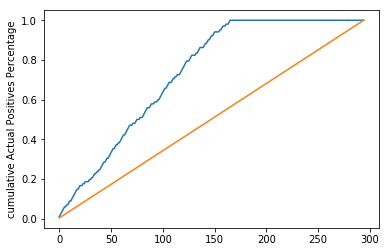

In [16]:
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

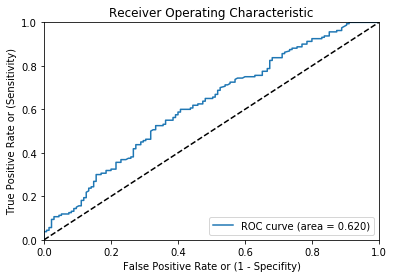

In [17]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 2017 Register to Apply (Boosted Tree)

In [18]:
df_2017 = df_raw.loc[df_raw['year'] == 2017]
df_2017_xy = df_2017.iloc[:,:58].drop(['Dealer ID','No. of Employees','year','applied 2016','JS 16.Column3','JS 18.Column3','JS 19.Column3','NON USER 16.Column3','NON USER 18.Column3','centurty 18.Column3','Gibson 18.Column3','Hitting Potential 16.Column3'],axis=1)
train_df = df_2017_xy.loc[df_2017_xy['train_test'] == 1].drop('train_test',axis = 1)
test_df = df_2017_xy.loc[df_2017_xy['train_test'] == 0].drop('train_test',axis = 1)
x_train = train_df.iloc[:,:44]
y_train = train_df['applied 2017']
x_test = test_df.iloc[:,:44]
y_test = test_df['applied 2017']
features = [c for c in df_2017_xy.columns if c not in ['applied 2017','train_test']]
categorical_feats = features

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

In [20]:
'''
set parameters
'''
param = {
            'num_leaves': 52,
            'min_data_in_leaf': 94, 
            'objective':'binary',
            'max_depth': 9,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 1,
            "bagging_freq": 1,
            "bagging_fraction": 1,
            "bagging_seed": 11,
            "lambda_l1": 5.96,
            "verbosity": -1
        }

In [21]:
'''
run boosted tree
'''
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

pred_0_1 = [0]*len(predictions)
for i in range(x_train.shape[0]):
        if oof[i] >= 0.5:
            oof[i] = 1
        else:
            oof[i] = 0
for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            pred_0_1[i] = 1
        else:
            pred_0_1[i] = 0
print("CV score: {:<8.5f}".format(accuracy_score(oof, y_train.values)))
print("Test Accuracy:{:<8.5f}".format(accuracy_score(pred_0_1, y_test.values)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.670071	valid_1's binary_logloss: 0.682897
fold n°1
Training until validation scores don't improve for 200 rounds.


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.66259	valid_1's binary_logloss: 0.682554
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.680203	valid_1's binary_logloss: 0.69093
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.670462	valid_1's binary_logloss: 0.684249
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.674571	valid_1's binary_logloss: 0.685859
CV score: 0.54462 
Test Accuracy:0.57490 


In [22]:
matrix = confusion_matrix(y_test.values, pred_0_1, labels=None, sample_weight=None)
df_matrix,df_summary = metrix_matrix(matrix)

In [23]:
df_matrix

,pred_0,pred_1
actual_0,84,42
actual_1,63,58


In [24]:
df_summary

,Value
Accuracy,0.574899
PPV,0.580000
NPV,0.571429
Sensitivity,0.479339
Specificity,0.666667


In [25]:
contractor_id = df_2017.loc[(df_2017['train_test'] == 0),'Dealer ID'].values
actual = y_test.values
predicted_prob = np.array(predictions)
predicted= pred_0_1

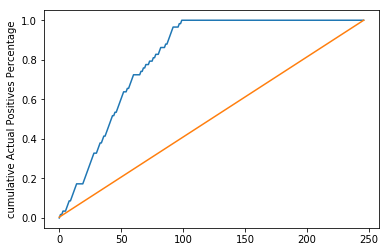

In [26]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

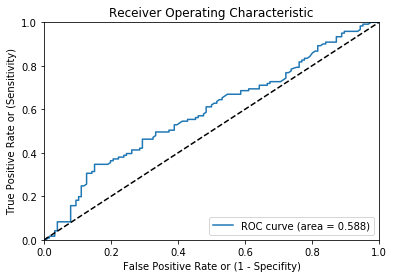

In [27]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Window 1 Year (Boosted Tree)

In [28]:
df_window_one_year = df_raw.loc[df_raw['applied_in_window_12months_or_not'] != 'Not enough info']
x_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,:56].drop(['Dealer ID','year','train_test','No. of Employees'],axis=1)
y_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,73].astype(int)
x_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,:56].drop(['Dealer ID','year','train_test','No. of Employees'],axis=1)
y_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,73].astype(int)
features = [c for c in x_train.columns]
categorical_feats = features

In [109]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... | threshold |
-------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.623652	valid_1's binary_logloss: 0.643861
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.609635	valid_1's binary_logloss: 0.66187
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.626027	valid_1's binary_logloss: 0.637036
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.606913	valid_1's binary_logloss: 0.639253
fold n°4
Training until validation scores don't imp

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.619477	valid_1's binary_logloss: 0.622707
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.620261	valid_1's binary_logloss: 0.627028
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.611533	valid_1's binary_logloss: 0.652912
|  52       |  0.636    |  1.0      |  1.0      |  5.871    |  4.002    |  56.09    |  22.88    |  0.5      |
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.629172	valid_1's binary_logloss: 0.647551
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.607282	valid_1's binary_log

fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.61499	valid_1's binary_logloss: 0.633016
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.619971	valid_1's binary_logloss: 0.652967
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.616763	valid_1's binary_logloss: 0.621619
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.614959	valid_1's binary_logloss: 0.625702
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.617284	valid_1's binary_logloss: 0.654233
|  60       |  0.6363   |  1.0      |  1.0      |  5.964    |  4.033    |  10.24    |  2

In [29]:
'''
set parameters
'''
param = {
            'num_leaves': 113,
            'min_data_in_leaf': 88, 
            'objective':'binary',
            'max_depth': 9,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 1,
            "bagging_freq": 1,
            "bagging_fraction": 1,
            "bagging_seed": 11,
            "lambda_l1": 5.844,
            "verbosity": -1
        }

In [30]:
'''
run boosted tree
'''
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

pred_0_1 = [0]*len(predictions)
for i in range(x_train.shape[0]):
        if oof[i] >= 0.5:
            oof[i] = 1
        else:
            oof[i] = 0
for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            pred_0_1[i] = 1
        else:
            pred_0_1[i] = 0
print("CV score: {:<8.5f}".format(accuracy_score(oof, y_train.values)))
print("Test Accuracy:{:<8.5f}".format(accuracy_score(pred_0_1, y_test.values)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.621015	valid_1's binary_logloss: 0.641087


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.613387	valid_1's binary_logloss: 0.654815
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.613721	valid_1's binary_logloss: 0.635524
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.614834	valid_1's binary_logloss: 0.638429
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.608756	valid_1's binary_logloss: 0.666223
CV score: 0.63893 
Test Accuracy:0.65930 


In [31]:
matrix = confusion_matrix(y_test.values, pred_0_1, labels=None, sample_weight=None)
df_matrix,df_summary = metrix_matrix(matrix)

In [32]:
df_matrix

,pred_0,pred_1
actual_0,56,240
actual_1,22,451


In [33]:
df_summary

,Value
Accuracy,0.659298
PPV,0.652677
NPV,0.717949
Sensitivity,0.953488
Specificity,0.189189


In [34]:
contractor_id = df_window_one_year.loc[(df_window_one_year['train_test'] == 0),'Dealer ID'].values
actual = y_test.values
predicted_prob = np.array(predictions)
predicted= pred_0_1

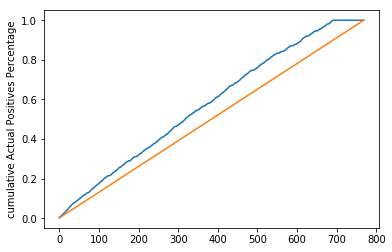

In [35]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

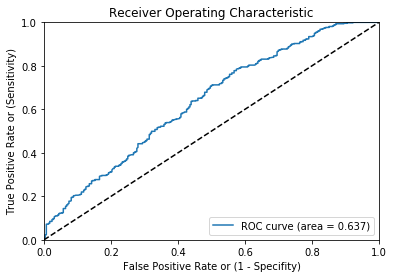

In [36]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")